# IDENTIFICANDO VALORES ATÍPICOS EN LA SERIE TEMPORAL

Es común que al trabajar con datos se presenten observaciones que son significativamente diferentes de la mayoría. Pueden ser el resultado de un precio incorrecto o un error en el procesamiento de los datos y así sucesivamente. Muchos algoritmos de aprendizaje pueden verse influenciados por valores atípicos, lo que conduce a resultados incorrectos/sesgados.

En este ejemplo se detectaran valores atípicos utilizando el enfoque 3&sigma; e identificandolos en un gráfico

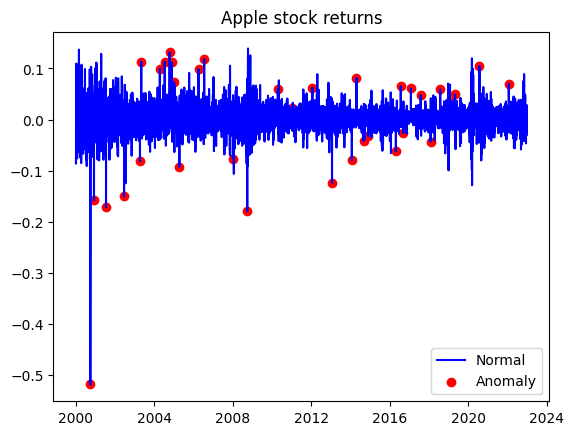

In [2]:
#Importando librerías

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

#Descarga de datos para mantener solo precios de cierre ajustados

df = yf.download('AAPL',
                 start='2000-01-01',
                 end='2022-12-31',
                 progress=False)

df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

#Calcular los rendimientos simples y logaritmicos

df['simple_rtn'] = df.adj_close.pct_change() #Rendimientos simples

#Calculando la media movil y la desviación estándar

df_rolling = df[['simple_rtn']].rolling(window=21)\
                               .agg(['mean', 'std'])

df_rolling.columns = df_rolling.columns.droplevel()

#Uniendo las medias móviles a los datos originales

df_outliers = df.join(df_rolling)

#Definiendo una función para detectar valores atípicos

def identify_outliers(row, n_signas=3):
    ''' 
    Función para identificar los valores atípicos utilizando la regla 3 sigma.
    La fila debe contener las siguientes columnas / índices: simple_rtn, mean, std.
    
    Parámetros

    row: pd.Series
        Una fila de un pd.DataFrame, sobre la cual se puede aplicar la función
    
    n_sigmas: int
        El número de desviaciones estándar por encima/por debajo de la media,
        utilizado para detectar valores atípicos

    Return

    0/1: int

        Un número entero que con 1 indica un valor atípico y 0 en caso contrario
    '''

    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']

    if(x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    
    else: 
        return 0
    

#Identificando los valores atipicos y extrayendo sus valores

df_outliers['outlier'] = df_outliers.apply(identify_outliers,
                                           axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1,
                           ['simple_rtn']]

#Graficando los resultados

fig, ax = plt.subplots()
ax.plot(df_outliers.index, df_outliers.simple_rtn,
        color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn,
           color='red', label='Anomaly')
ax.set_title('Apple stock returns')
ax.legend(loc='lower right')

plt.show()